## Matrix method for the Kronig-Penney model, periodic conditions

El chiste de este notebook es obtener los mismos resultados de las bandas de energía para un potencial dado por un arreglo en lugar de por una función, esto para extender la variedad de potenciales que se pueden usar.

Recordando del notebook "Kronig_Penny_model_1D" tenemos que resolver de eigenvalores
$$\sum_{m=1}^\infty H_{nm} c_m = E c_n$$
Donde se trabajá con la versión adimensional
$$h_{nm} = \frac{H_{nm}}{E_0} = 4n^2 \delta_{nm} + \frac{1}{a}\int_{-\frac{a}{2}}^\frac{a}{2}\frac{V(x)}{E_0} e^{-i \frac{2\pi (n-m)}{a}x} dx$$

En el caso anterior se utilizó un potencial cuadrado dado por
$$V(x) = V_0 \sum_{n=-\infty}^{\infty} \theta[x-(na-b)]\theta[(n+1)a-x]$$
Donde la función $\theta$ es la función de Heaviside.

y se encontró la expresión para $h_{nm}$ siguiente

$$h_{nm} = \delta_{nm} \left[\left(2n+\frac{Ka}{\pi}\right)^2+v_0(1-\rho)\right]+ (1-\delta_{nm})v_0 \frac{(-1)^{m-n+1}}{\pi}\frac{\sin(\pi(m-n)\rho)}{m-n}$$

Donde $\rho = b/a$ y $v_0 = V_0/E_0$

Usando esta realción se contruyó de forma "exacta" la matriz del hamiltoniano adimencional y se encontraron sus eigenvalores.

In [1]:
import numpy as np
from numpy import linalg as LA
from matplotlib.pyplot import *
from scipy.integrate import quad, trapz
%matplotlib inline

In [ ]:
heaviside = lambda x: 0.5 if x == 0 else 0 if x < 0 else 1

def potencial_num(x, v0, rho):
    v = np.zeros_like(x)
    for i in range(len(x)):
        for n in range(-3,3):
            v[i]+= v0*heaviside((x[i]-(1-rho)/2)-(n+rho))*heaviside(n+1-(x[i]-(1-rho)/2))
    return v

In [2]:
def Hamiltonian(N, K, v0, rho):
    h = np.zeros((2*N+1,2*N+1))
    for n in range(-N,N+1):
        for m in range(-N,N+1):
            if n==m:
                h[m,n] = (2*n+K)*(2*n+K) + v0*(1-rho)
            else:
                if (m-n+1)%2==0:
                    h[m,n] = v0*np.sin(np.pi*(m-n)*rho)/(np.pi*(m-n))
                else:
                    h[m,n] = -v0*np.sin(np.pi*(m-n)*rho)/(np.pi*(m-n))
    return h

def ParseKa(Ka_vals, N, v0, rho):
    Ka = np.linspace(-1, 1, Ka_vals)
    Eigenvals = np.zeros((Ka_vals, 2*N+1))
    for i in xrange(Ka_vals):
        H = Hamiltonian(N, Ka[i], v0, rho)
        Eigenvals[i] = LA.eigvalsh(H)
        
    Energies = np.zeros((2,(2*N+1)*Ka_vals))
    for j in xrange(2*N+1):
        for i in xrange(Ka_vals):
            Energies[:,i*(2*N+1)+j] = [Ka[i],Eigenvals[i,j]]
    return Energies

Resultados de aplicar este método son

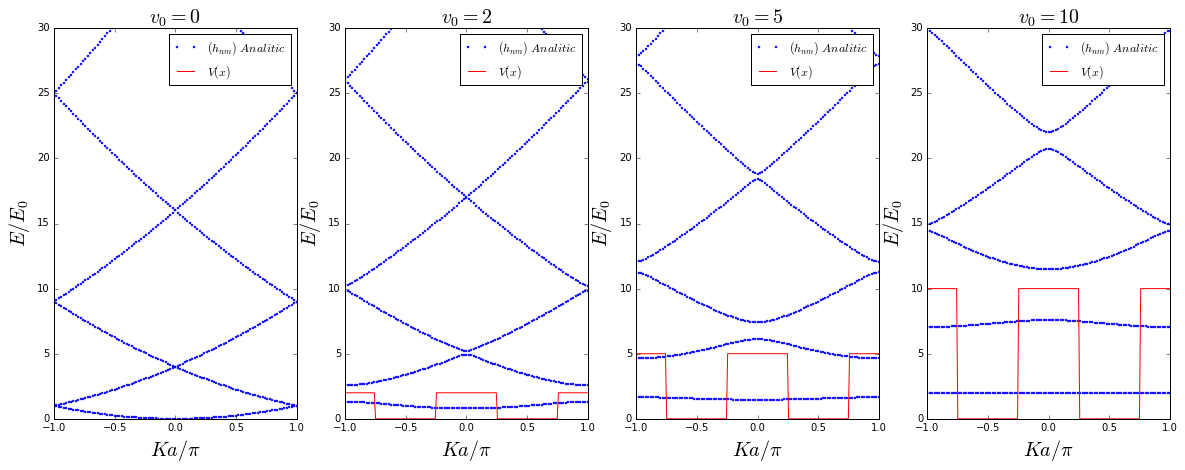

In [16]:
fig = figure(figsize=(20,7))
ax = fig.add_subplot(141)
bx = fig.add_subplot(142)
cx = fig.add_subplot(143)
dx = fig.add_subplot(144)

Ka_vals = 101
N = 10
rho = 0.5
v0s = [0, 2, 5, 10]

Energies = [np.zeros((Ka_vals, 2*N+1)), np.zeros((Ka_vals, 2*N+1)), 
            np.zeros((Ka_vals, 2*N+1)), np.zeros((Ka_vals, 2*N+1))]
graphs = [ax,bx,cx,dx]

x = np.linspace(-1,1,200)

for i in range(4):
    Energies[i] = ParseKa(Ka_vals, N, v0s[i], rho)
    graphs[i].plot(Energies[i][0,:], Energies[i][1,:], '.', markersize=4, label="$(h_{nm})\ Analitic$")
    graphs[i].plot(x, potencial_num(x, v0s[i], rho), 'r', label="$V(x)$")
    graphs[i].set_title("$v_0 = "+str(v0s[i])+"$", fontsize=20)
    graphs[i].set_ylim(0,30)
    graphs[i].set_xlabel("$Ka/\pi$", fontsize=20)
    graphs[i].set_ylabel("$E/E_0$", fontsize=20)
    graphs[i].legend()

## Replicar el hamiltoniano de forma numérica y no analítica

Sabemos que la matriz hamiltoniana es 
$$h_{nm} = \frac{H_{nm}}{E_0} = 4n^2 \delta_{nm} + \frac{1}{a}\int_{-\frac{a}{2}}^\frac{a}{2}\frac{V(x)}{E_0} e^{-i \frac{2\pi (n-m)}{a}x} dx$$

Por lo que tenemos que hayar la forma de encontrar numéricamente el valor de 
$$\int_{-\frac{1}{2}}^\frac{1}{2}\frac{V(x/a)}{E_0} e^{- 2\pi i (n-m)x} dx$$

In [4]:
def potencial(x, v0, rho):
    v = 0
    for n in range(-3,3):
        v+= v0*heaviside((x-(1-rho)/2)-(n+rho))*heaviside(n+1-(x-(1-rho)/2))
    return v

def potencial_func_base(x, n, m, v0, rho):
    return potencial(x,v0,rho)*0.5*np.exp(-2.0j*np.pi*(n-m)*x)

In [5]:
def Potencial_numeric(N, v0, rho):
    v_nm = np.zeros((2*N+1, 2*N+1), dtype=np.complex64)
    disq = [0.5*(-1-rho), 0.5*(-1+rho),0.5*(1-rho), 0.5*(1+rho)]
    for m in range(-N,N+1):
        for n in range(m,N+1): 
            I = quad(potencial_func_base, -1.0, 1.0, args=(n, m, v0, rho), points=disq)[0]
            v_nm[m,n] = I
            v_nm[n,m] = I
    return v_nm

def Hamiltonian_numeric(N, Ka, v0, rho):
    h = np.zeros((2*N+1,2*N+1), dtype=np.complex64)
    for n in range(-N, N+1):
        for m in range(-N, N+1):
            if n==m:
                h[m,n] = (2*n+Ka)*(2*n+Ka)
    
    h = h + Potencial_numeric(N, v0, rho)
    return h

def ParseKa_numeric(Ka_vals, N, v0, rho):
    Ka = np.linspace(-1, 1, Ka_vals)
    Eigenvals = np.zeros((Ka_vals, 2*N+1))
    
    for i in xrange(Ka_vals):
        H = Hamiltonian_numeric(N, Ka[i], v0, rho)
        Eigenvals[i] = np.real(LA.eigvalsh(H))
    
    Energies = np.zeros((2,(2*N+1)*Ka_vals))
    for j in xrange(2*N+1):
        for i in xrange(Ka_vals):
            Energies[:,i*(2*N+1)+j] = [Ka[i],Eigenvals[i,j]]
    return Energies


### Comparación entre los métodos

#### Para $\rho$ constante

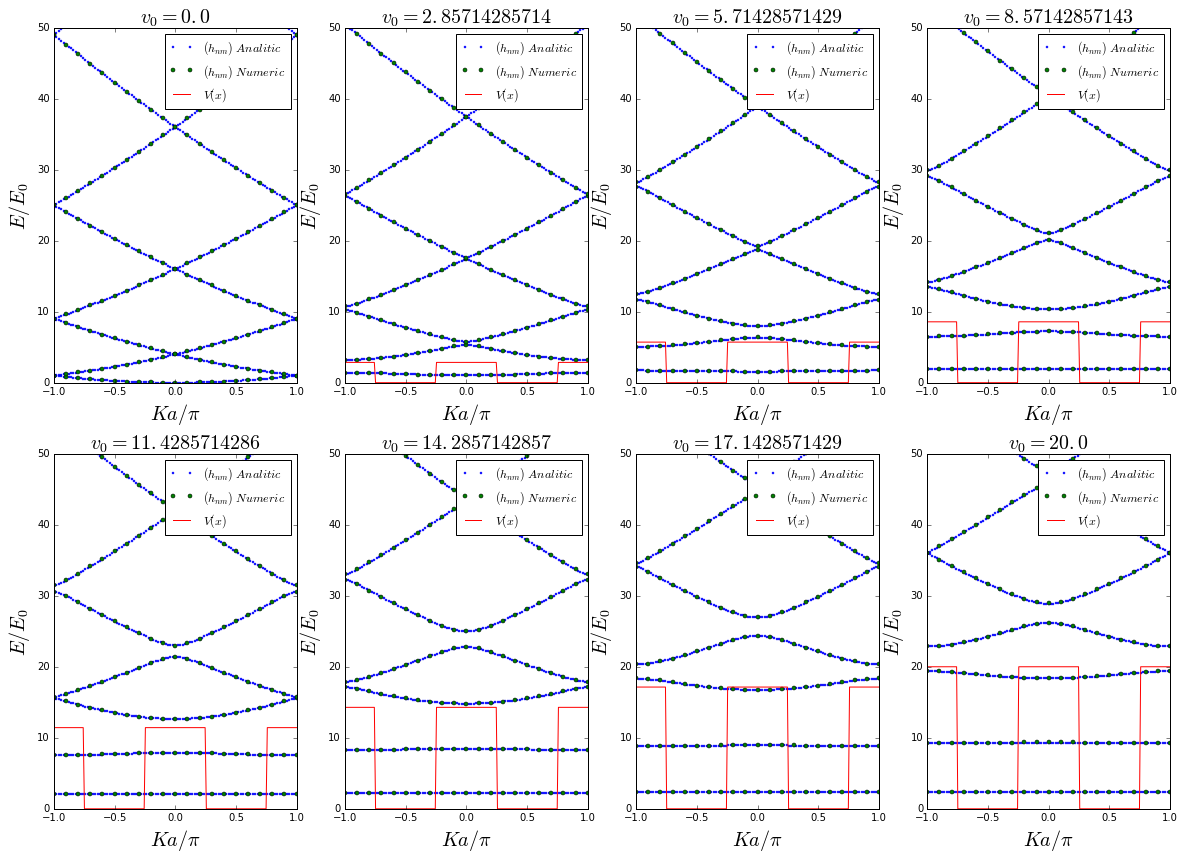

In [17]:
fig = figure(figsize=(20,14))
ax = fig.add_subplot(241)
bx = fig.add_subplot(242)
cx = fig.add_subplot(243)
dx = fig.add_subplot(244)
ex = fig.add_subplot(245)
fx = fig.add_subplot(246)
gx = fig.add_subplot(247)
hx = fig.add_subplot(248)
graphs = [ax,bx,cx,dx,ex,fx,gx,hx]

Ka_vals = 101
Ka_vals_numeric = 21
N = 10
N_numeric = 5
rho = 0.5
v0s = np.linspace(0,20,8)

Energies = np.zeros((Ka_vals, 2*N+1))
Energies_numeric = np.zeros((Ka_vals, 2*N+1))
x = np.linspace(-1,1,200)

for i in range(len(graphs)):
    Energies = ParseKa(Ka_vals, N, v0s[i], rho)
    Energies_numeric = ParseKa_numeric(Ka_vals_numeric, N_numeric, v0s[i], rho)
    graphs[i].plot(Energies[0,:], Energies[1,:], '.', markersize=4, label="$(h_{nm})\ Analitic$")
    graphs[i].plot(Energies_numeric[0,:], Energies_numeric[1,:], 'o', markersize=4, label="$(h_{nm})\ Numeric$")
    graphs[i].plot(x, potencial_num(x, v0s[i], rho), 'r', label="$V(x)$")
    graphs[i].set_title("$v_0 = "+str(v0s[i])+"$", fontsize=20)
    graphs[i].set_ylim(0,50)
    graphs[i].set_xlabel("$Ka/\pi$", fontsize=20)
    graphs[i].set_ylabel("$E/E_0$", fontsize=20)
    graphs[i].legend()

#### Para $v_0$ constante

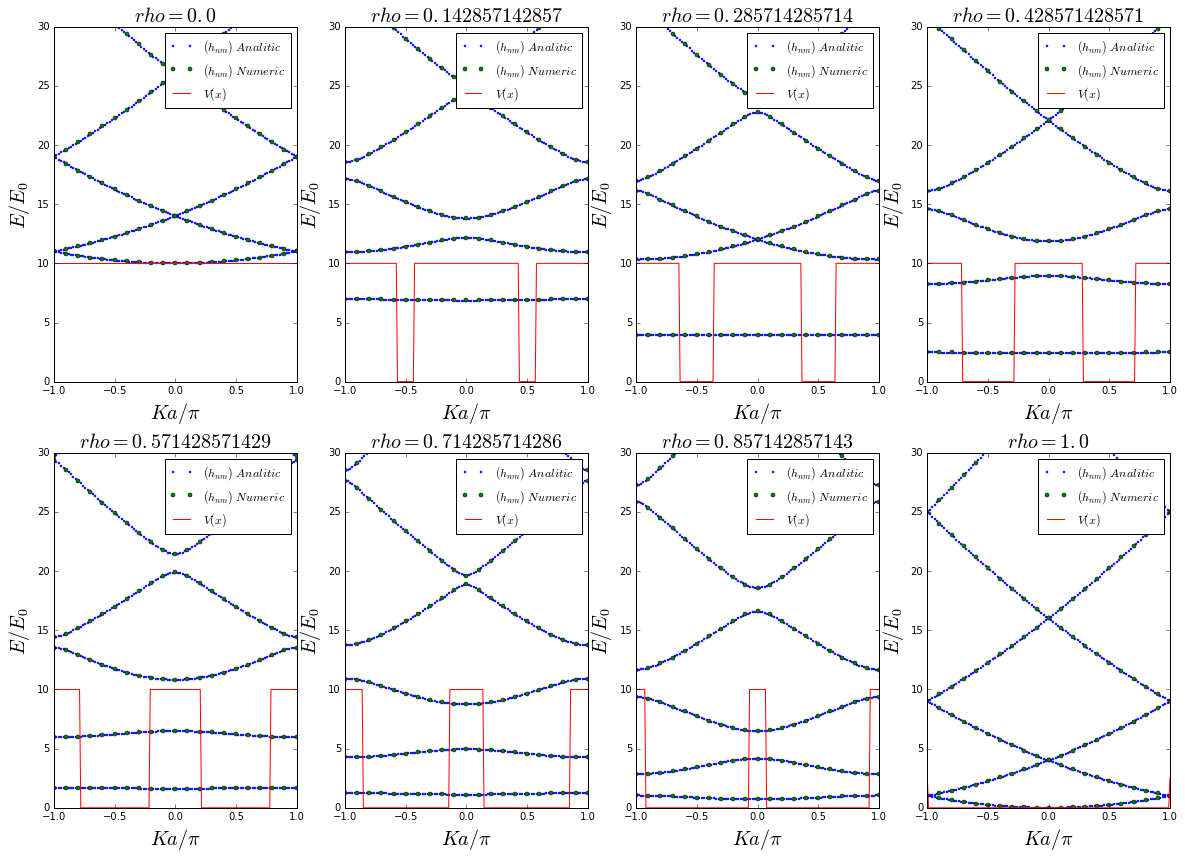

In [19]:
fig = figure(figsize=(20,14))
ax = fig.add_subplot(241)
bx = fig.add_subplot(242)
cx = fig.add_subplot(243)
dx = fig.add_subplot(244)
ex = fig.add_subplot(245)
fx = fig.add_subplot(246)
gx = fig.add_subplot(247)
hx = fig.add_subplot(248)
graphs = [ax,bx,cx,dx,ex,fx,gx,hx]

Ka_vals = 101
Ka_vals_numeric = 21
N = 10
N_numeric = 5
v0 = 10
rhos = np.linspace(0,1,8)

Energies = np.zeros((Ka_vals, 2*N+1))
Energies_numeric = np.zeros((Ka_vals_numeric, 2*N+1))
x = np.linspace(-1,1,200)

for i in range(len(graphs)):
    Energies = ParseKa(Ka_vals, N, v0, rhos[i])
    Energies_numeric = ParseKa_numeric(Ka_vals_numeric, N_numeric, v0, rhos[i])
    graphs[i].plot(Energies[0,:], Energies[1,:], '.', markersize=4, label="$(h_{nm})\ Analitic$")
    graphs[i].plot(Energies_numeric[0,:], Energies_numeric[1,:],  'o',markersize=4, label="$(h_{nm})\ Numeric$")
    graphs[i].plot(x, potencial_num(x, v0, rhos[i]), 'r', label="$V(x)$")
    graphs[i].set_title("$rho = "+str(rhos[i])+"$", fontsize=20)
    graphs[i].set_ylim(0,30)
    graphs[i].set_xlabel("$Ka/\pi$", fontsize=20)
    graphs[i].set_ylabel("$E/E_0$", fontsize=20)
    graphs[i].legend()